<p style="font-size: 30px; font-weight: bold; text-align: center">Survival analysis for coup d'etats in Africa</p>

Since the 1960s, coups d'état have been a regular occurrence in most African countries. Although their number has tended to decline since the early 2000s, they remain regular and continue to shape the geopolitics of the African continent.

Thanks to a dataset from the <a href="https://clinecenter.illinois.edu/project/research-themes/democracy-and-development/coup-detat-project">'Coup d'État'</a> project at the University of Illionois and the <a href="https://documents.worldbank.org/en/publication/documents-reports/api">World Bank's api</a>, we're going to apply survival analysis to better understand and try to predict coups d'état in Africa.

Survival analyses were carried out thanks to the <a href="https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html#The-Survival-Function">introduction to survival analyses</a> in the Scikit-survival documentation.

---
# Imports

In [2]:
import sklearn
from sklearn import set_config
from sklearn import preprocessing
import sksurv
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 100
import wbgapi as wb

---

# Import dataframes

Our starting point is a dataframe we created in a notebook using data from a dataframe from the University of Illinois' 'Coup d'État' project and data from the World Bank's api. 

We decided to use the World Bank data because it is available for all African countries and is fairly complete for these countries from 1960 to 2022. We could have used other data more related to coups d'état, such as data on politics or corruption.

Our dataset takes into account **coups and attempted coups**. Each line represents a period. The period can be between :
 - The creation of a state and a coup d'état
 - The creation of a state and 2022
 - Two coups
 - A coup d'état and 2022

The start and end of each period are modeled by the `Start` and `End` variables. The duration of the period is modeled by the variable `Duration`, and the binary variable `Status` lets us know whether the period is still running or has ended.

In [3]:
data = pd.read_csv("data/data_coups.csv")
var_description = pd.read_csv("data/var_description.csv")

This is what our initial dataset looks like :

In [4]:
data

,Unnamed: 0,Country,Start,End,Duration,Status,AG.CON.FERT.ZS,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,...,TX.VAL.MRCH.AL.ZS,TX.VAL.MRCH.CD.WT,TX.VAL.MRCH.HI.ZS,TX.VAL.MRCH.OR.ZS,TX.VAL.MRCH.R1.ZS,TX.VAL.MRCH.R5.ZS,TX.VAL.MRCH.R6.ZS,TX.VAL.MRCH.RS.ZS,TX.VAL.MRCH.WL.CD,TX.VAL.MRCH.WR.ZS
0,0,Algeria,1950,1962,12,True,8.150617,451855.000000,18.971634,6.386000e+06,...,1.358576,3.176667e+08,94.312623,3.060419,0.129405,0.025491,2.760445,1.383091,3.783500e+08,1.243868
1,1,Algeria,1962,1964,2,True,8.613397,445246.666667,18.694176,6.210667e+06,...,NaN,5.593333e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Algeria,1964,1965,1,True,7.428815,441655.000000,18.543376,6.167500e+06,...,NaN,6.820000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Algeria,1965,1967,2,True,7.573438,441950.000000,18.555762,6.241667e+06,...,1.350557,6.603333e+08,91.114369,3.224294,0.651341,0.069137,1.593262,4.310780,6.722000e+08,1.350557
4,4,Algeria,1967,1991,24,True,23.535864,419201.600000,17.600645,6.768600e+06,...,1.235105,7.296960e+09,87.872283,3.526906,0.454926,0.271748,0.883927,7.428177,7.157495e+09,1.172634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,436,Zimbabwe,1950,1999,49,True,48.803900,124808.717949,32.262820,2.612564e+06,...,1.927944,1.071800e+09,55.139005,7.486393,3.742658,0.950243,33.552662,3.821940,1.293364e+09,33.552662
437,437,Zimbabwe,1999,2006,7,True,36.612162,155825.000000,40.280470,3.731250e+06,...,1.349538,1.804750e+09,38.141610,14.623773,10.835183,0.663717,35.621718,11.612899,2.099343e+09,35.621718
438,438,Zimbabwe,2006,2007,1,True,29.695796,162500.000000,42.005945,4.050000e+06,...,1.608265,2.200000e+09,25.219798,7.652067,3.131340,0.288978,67.004419,0.123716,1.869048e+09,67.004419
439,439,Zimbabwe,2007,2017,10,True,26.992159,162500.000000,42.005945,4.050000e+06,...,5.318844,3.209000e+09,17.691256,3.639799,2.683588,0.267680,72.768358,5.900587,3.024713e+09,72.768358


We also have a dataframe that lets us know the exact description of each variable.

In [5]:
var_description

,Unnamed: 0,id,description
0,0,AG.CON.FERT.ZS,Fertilizer consumption (kilograms per hectare ...
1,1,AG.LND.AGRI.K2,Agricultural land (sq. km)
2,2,AG.LND.AGRI.ZS,Agricultural land (% of land area)
3,3,AG.LND.ARBL.HA,Arable land (hectares)
4,4,AG.LND.ARBL.HA.PC,Arable land (hectares per person)
...,...,...,...
216,216,TX.VAL.MRCH.R5.ZS,Merchandise exports to low- and middle-income ...
217,217,TX.VAL.MRCH.R6.ZS,Merchandise exports to low- and middle-income ...
218,218,TX.VAL.MRCH.RS.ZS,"Merchandise exports by the reporting economy, ..."
219,219,TX.VAL.MRCH.WL.CD,Merchandise exports by the reporting economy (...


In [6]:
data = data.drop(columns=["Unnamed: 0"])
var_description = var_description.drop(columns=["Unnamed: 0"])
var_description = var_description.set_index("id")

---

# Manage `NA` values

To create our database, we used data from the world bank. The data starts in 1960, so we don't have data before this year. We can remove the rows that had a coup in 1960 or before.

In [7]:
data = data[data["End"]>1960]

In our situation, we can't repalce `NaN` values by means. What we can do is checking wich variables have to much `NaN` values. We will drop columns that have to much `NaN` values. After that, we will remove the last rows that have `NaN` values.

In [8]:
drop_columns = []
for i in data.columns :
    if data[i].isna().sum() > 10 :
        drop_columns.append(i)
        
print("Former column number :",len(data.columns))
print("New column number :", len(data.columns)-len(drop_columns))

Former column number : 226
New column number : 108


In [9]:
data = data.drop(columns=drop_columns)
data.index = range(len(data))

This is the columns we keep :

In [10]:
for col in data.columns :
    if col not in ["Country", "Duration", "Start", "End", "Status"] :
        print("-----------------------")
        print(col, ":", var_description.loc[col, "description"])

-----------------------
AG.LND.AGRI.K2 : Agricultural land (sq. km)
-----------------------
AG.LND.AGRI.ZS : Agricultural land (% of land area)
-----------------------
AG.LND.ARBL.HA : Arable land (hectares)
-----------------------
AG.LND.ARBL.HA.PC : Arable land (hectares per person)
-----------------------
AG.LND.ARBL.ZS : Arable land (% of land area)
-----------------------
AG.LND.CROP.ZS : Permanent cropland (% of land area)
-----------------------
AG.LND.TOTL.K2 : Land area (sq. km)
-----------------------
AG.SRF.TOTL.K2 : Surface area (sq. km)
-----------------------
BX.GRT.EXTA.CD.WD : Grants, excluding technical cooperation (BoP, current US$)
-----------------------
BX.GRT.TECH.CD.WD : Technical cooperation grants (BoP, current US$)
-----------------------
DC.DAC.DEUL.CD : Net bilateral aid flows from DAC donors, Germany (current US$)
-----------------------
DC.DAC.TOTL.CD : Net bilateral aid flows from DAC donors, Total (current US$)
-----------------------
DT.ODA.ALLD.CD : Ne

Finally, we remove the few periods for which we have missing data.

In [11]:
data = data.dropna(how='any')
data.index = range(len(data))

In [14]:
data

,Country,Start,End,Duration,Status,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,...,SP.POP.TOTL.MA.IN,SP.POP.TOTL.MA.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,TM.VAL.MRCH.CD.WT,TX.VAL.MRCH.CD.WT
0,Algeria,1950,1962,12,True,451855.000000,18.971634,6.386000e+06,0.546441,2.681233,...,5.850845e+06,50.479458,7.898244e+06,-0.327387,68.159667,5.902927,3.692148e+06,31.840333,8.936667e+08,3.176667e+08
1,Algeria,1962,1964,2,True,445246.666667,18.694176,6.210667e+06,0.518785,2.607617,...,6.071567e+06,50.697792,7.821427e+06,-0.565829,65.327667,5.896409,4.154177e+06,34.672333,5.930000e+08,5.593333e+08
2,Algeria,1964,1965,1,True,441655.000000,18.543376,6.167500e+06,0.502242,2.589493,...,6.256792e+06,50.949562,7.749016e+06,-0.643589,63.108000,5.816454,4.531162e+06,36.892000,6.870000e+08,6.820000e+08
3,Algeria,1965,1967,2,True,441950.000000,18.555762,6.241667e+06,0.494255,2.620633,...,6.454492e+06,51.101517,7.767218e+06,0.380435,61.504333,4.450623,4.863369e+06,38.495667,6.510000e+08,6.603333e+08
4,Algeria,1967,1991,24,True,419201.600000,17.600645,6.768600e+06,0.377896,2.841872,...,9.511017e+06,50.988162,1.024124e+07,1.871479,55.891000,4.147516,8.421825e+06,44.109000,6.459200e+09,7.296960e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,Zimbabwe,1950,1999,49,True,124808.717949,32.262820,2.612564e+06,0.368849,6.753429,...,3.611464e+06,48.579182,5.605716e+06,2.188283,77.330275,5.376845,1.857980e+06,22.669725,1.165350e+09,1.071800e+09
400,Zimbabwe,1999,2006,7,True,155825.000000,40.280470,3.731250e+06,0.310031,9.645211,...,5.699981e+06,47.383904,7.929302e+06,0.633800,65.916375,1.188194,4.100536e+06,34.083625,1.980250e+09,1.804750e+09
401,Zimbabwe,2006,2007,1,True,162500.000000,42.005945,4.050000e+06,0.326890,10.469174,...,5.845683e+06,47.178699,8.198310e+06,1.192892,66.165500,0.374291,4.192218e+06,33.834500,2.655000e+09,2.200000e+09
402,Zimbabwe,2007,2017,10,True,162500.000000,42.005945,4.050000e+06,0.303005,10.469174,...,6.307621e+06,47.015078,9.007344e+06,1.858943,67.108909,1.165234,4.409159e+06,32.891091,5.529182e+09,3.209000e+09


In our final dataframe, only one country is missing: **Somalia**. This is due to the fact that there was missing data for at least one variable in every period for this country.

---

# Descriptives statistics

To better understand our data, we can create a barplot to visualize the frequency of coups d'état from 1960 to 2022. Not all the coups or attempted coups that took place in Africa between 1960 and 2021 are present in our final dataset. The following representation therefore corresponds to the data present in our final dataset.

In [15]:
coups_by_year = {}

for i in range(len(data)) :
    if data.loc[i,"Status"] != False :
        coups_by_year[data.loc[i,"End"]] = 0

for i in range(len(data)) :
    if data.loc[i,"Status"] != False :
        coups_by_year[data.loc[i,"End"]] += 1
        
coups_by_year = {key: coups_by_year[key] for key in sorted(coups_by_year)}

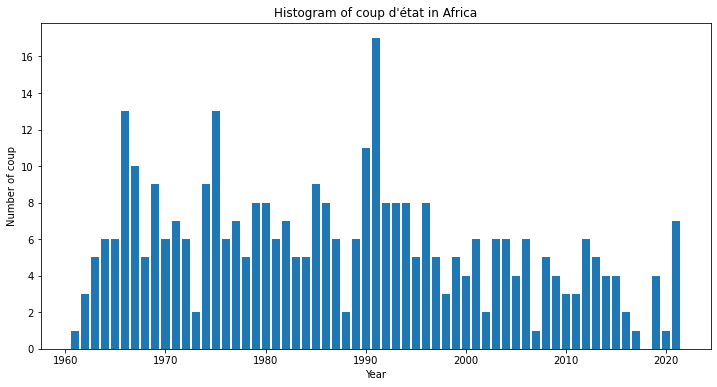

In [16]:
plt.figure(figsize=(12, 6))
plt.bar(coups_by_year.keys(), coups_by_year.values())
plt.title("Histogram of coup d'état in Africa")
plt.xlabel("Year")
plt.ylabel("Number of coup")
plt.show()

On this barplot, we can see that the number of coups d'état per year was higher in the 20th century than in the 21st. We also note peaks in coups and attempted coups in 1966, 1975 and 1991.

---

# Survival analysis

## Overall survival function

The survival function $S$ is defined by the following formula:
<br><br> $$S(t) = \mathbb{P}(T > t)$$<br>
Where $t$ is the time variable, $T$ a random variable defining the time at which the event ends and $\mathbb{P}$ the probability function. The survival function defines the probability of the event ending after time $t$.

For more informations on survival functions you can check these two links :
- <a href="https://en.wikipedia.org/wiki/Survival_analysis">Wikipedia</a>
- <a href="https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html">Scikit-survival</a>

We apply this method with our data to get an overall survival function.

In [17]:
time, survival_prob = kaplan_meier_estimator(data['Status'], data['Duration'])

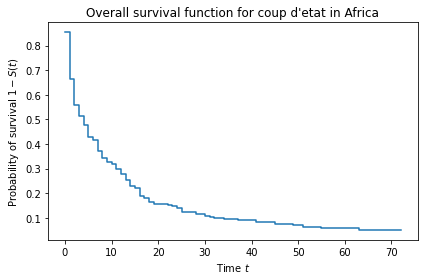

In [18]:
fig, ax = plt.subplots()
ax.step(time, survival_prob, where='post')
ax.set_ylabel('Probability of survival $1-S(t)$')
ax.set_xlabel('Time $t$')
plt.title("Overall survival function for coup d'etat in Africa")
plt.tight_layout()

## Survival function by variables factors

We'll now try to see how each variable influences the survival curve. To do this, we'll transform our continuous variables into four-factor discrete variables. Each factor represents a quartile of the variable.

To achieve this, we've created 3 functions:
- `factor_transformation`: Takes as input the dataset and the desired variable. Transforms the continuous variable into a four-factor discrete variable and returns a Pandas series of the discrete variable.
- `data_sf_factors`: Takes as input the dataset and the desired variable. Concatenates the variables `Country`, `Start`, `End`, `Duration` and `Status` with the discrete variable from the `factor_transformation` function. Returns a Pandas dataframe of concatenated variables.
- `plot_sf_factors`: Takes as input the dataset and the desired variable. Returns a representation of the survival curve for each factor of the desired variable that has been transformed into a discrete variable.

In [19]:
def factor_transformation(data, var) :
    bins = [min(data[var])-1, np.percentile(data[var], 25), np.percentile(data[var], 50), np.percentile(data[var], 75), max(data[var])]
    categories = pd.cut(data[var], bins=bins, labels=["<{}".format(round(np.percentile(data[var], 25), 2)), 
                                                      "{}<i<{}".format(round(np.percentile(data[var], 25),2), round(np.percentile(data[var], 50)),2), 
                                                      "{}<i<{}".format(round(np.percentile(data[var], 50),2), round(np.percentile(data[var], 75)),2), 
                                                      ">{}".format(round(np.percentile(data[var], 75)),2)])
    return categories

def data_sf_factors(data, var) :
    factor_column = factor_transformation(data, var)
    new_df = data.loc[:,["Country", "Start", "End", "Duration", "Status"]]
    new_df["var_fact"] = factor_column
    return new_df

def plot_sf_factors(data, var) :
    df = data_sf_factors(data, var)
    for i in set(df["var_fact"]) :
        new_df = df[df["var_fact"] == i]
        time, survival_prob = kaplan_meier_estimator(new_df['Status'], new_df['Duration'])
        plt.step(time, survival_prob, where='post', label = i)
    plt.ylabel('Probability of survival $1-S(t)$')
    plt.xlabel('Time $t$')
    title = "Survival curves of {}".format(var_description.loc[var, "description"])
    if len(title) > 60 :
        title = " {} \n {}".format(title[:60], title[60:])
    plt.title(title)
    plt.legend()
    plt.tight_layout()

In [20]:
variables = [i for i in data.columns if i not in ["Country", "Start", "End", "Duration", "Status"]]
sub_list_var = [variables[i:i+2] for i in range(0, len(variables), 2)]

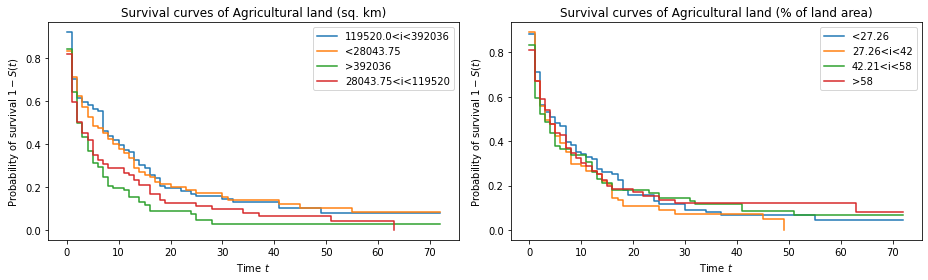

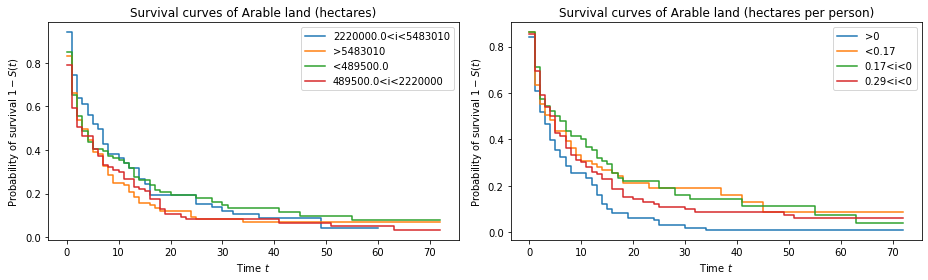

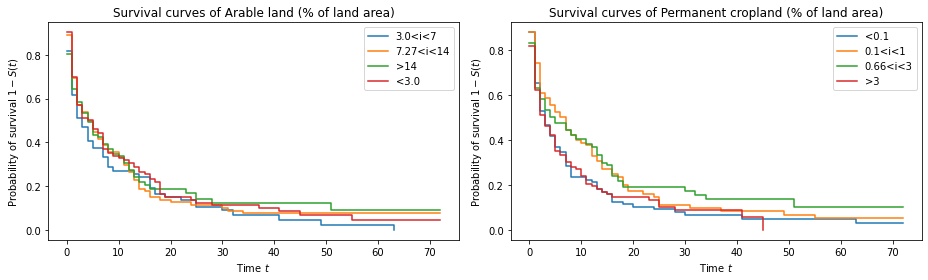

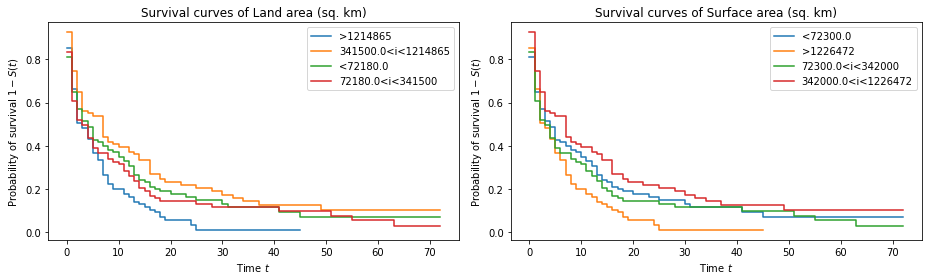

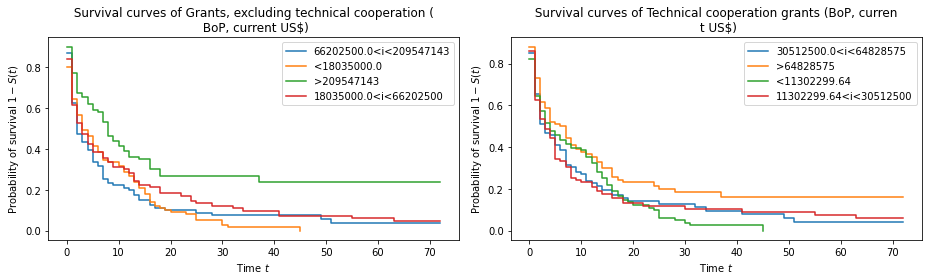

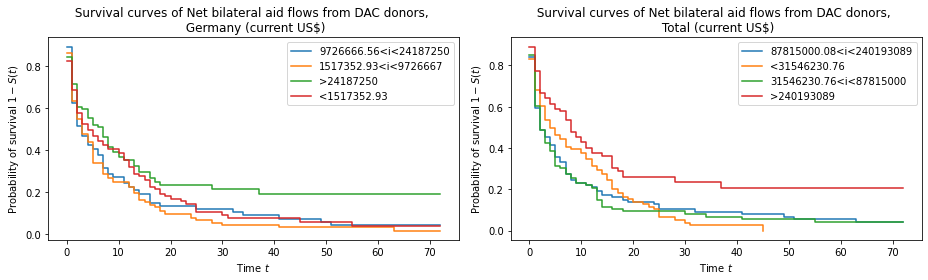

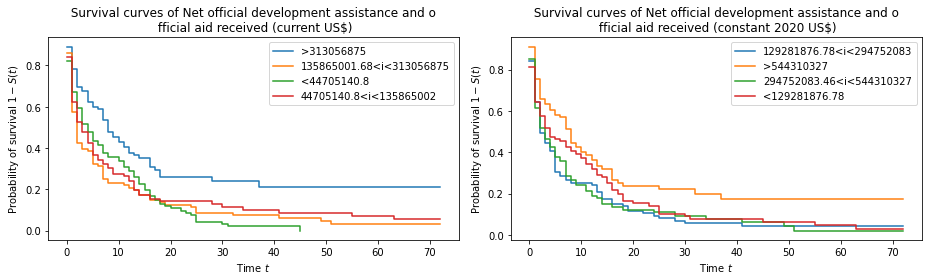

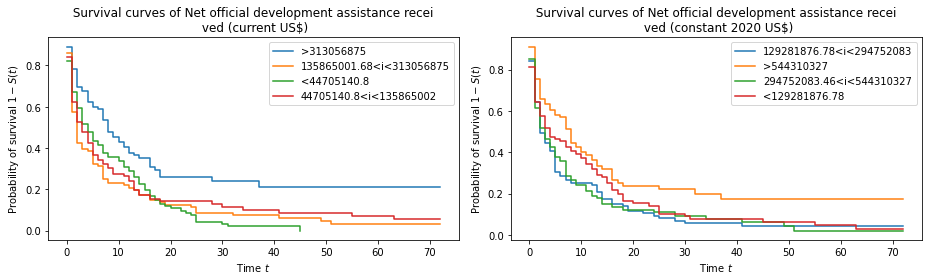

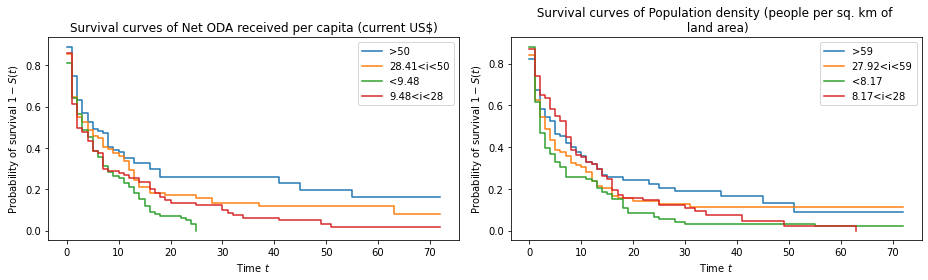

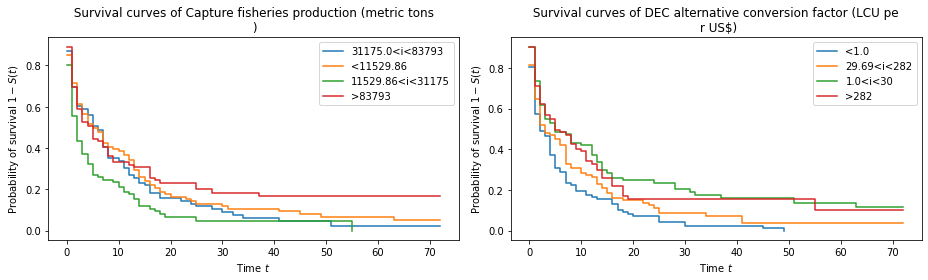

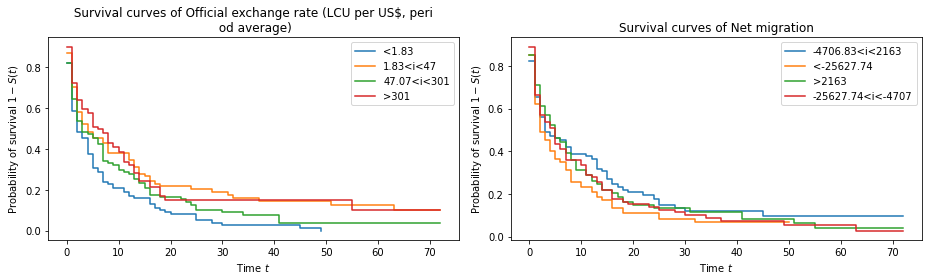

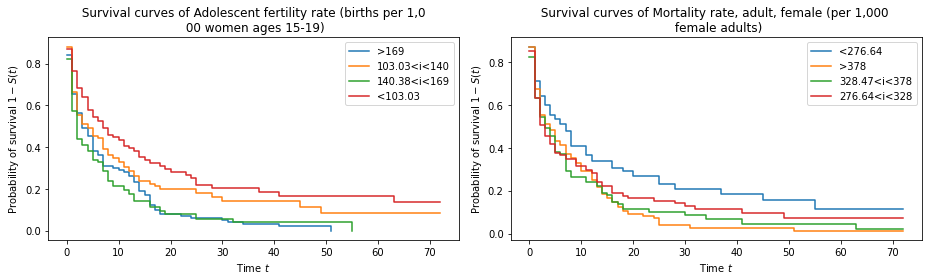

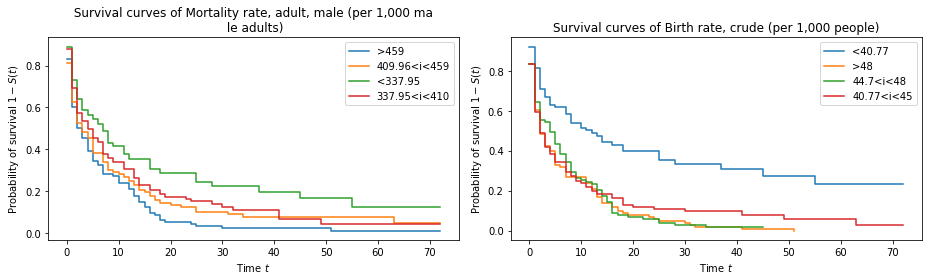

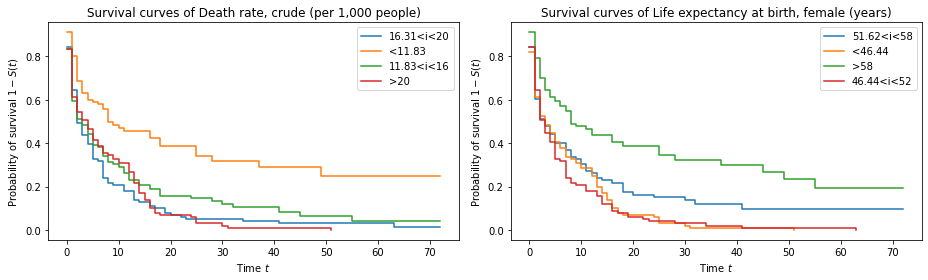

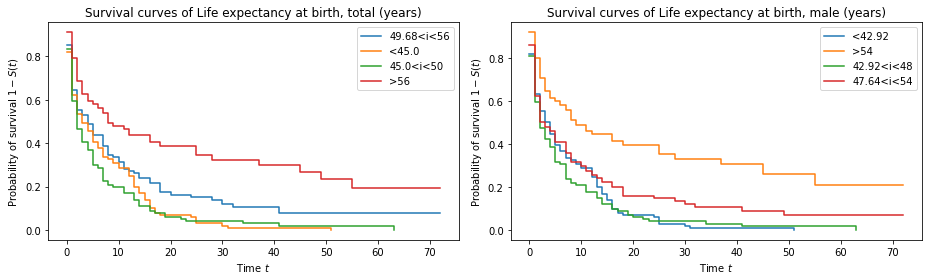

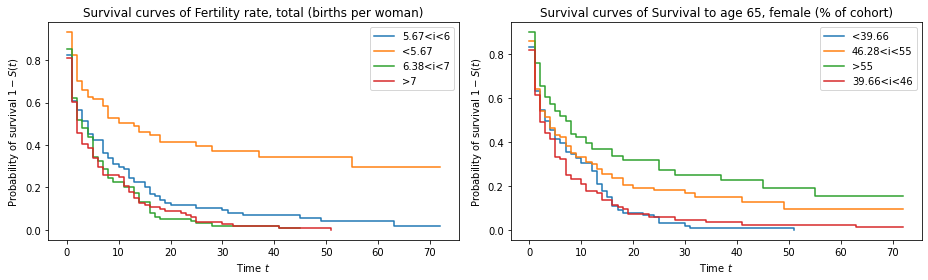

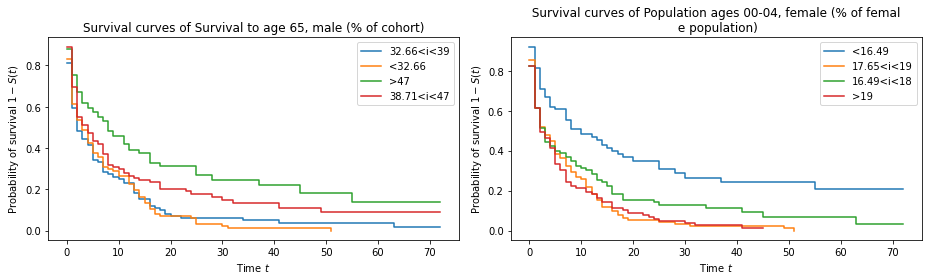

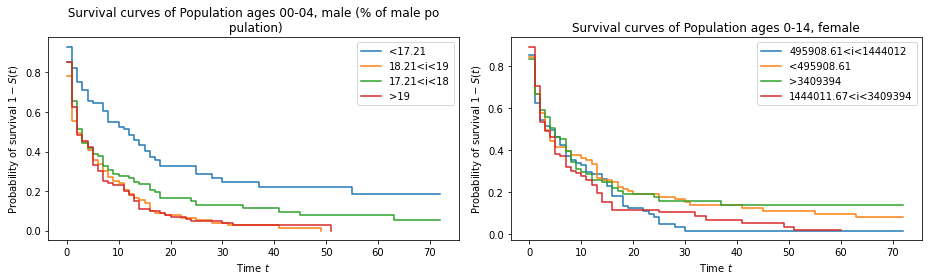

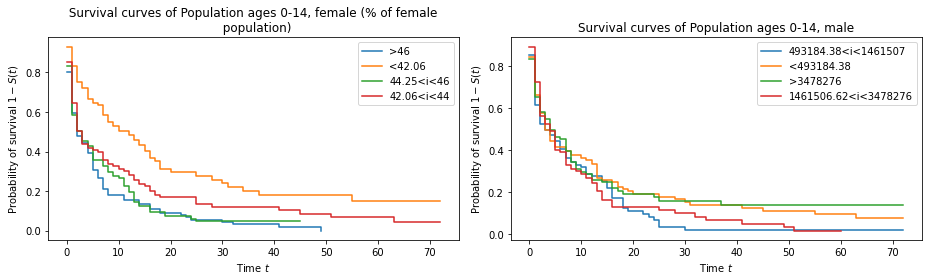

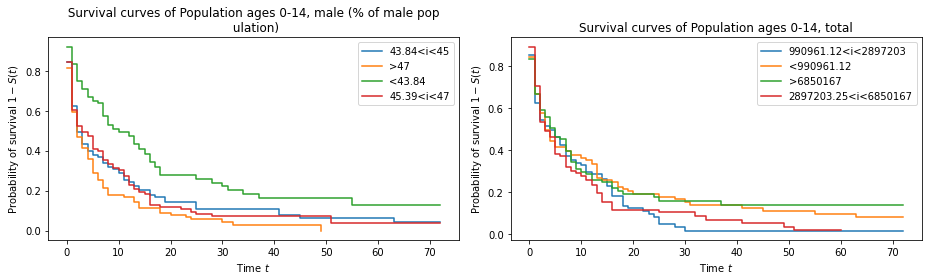

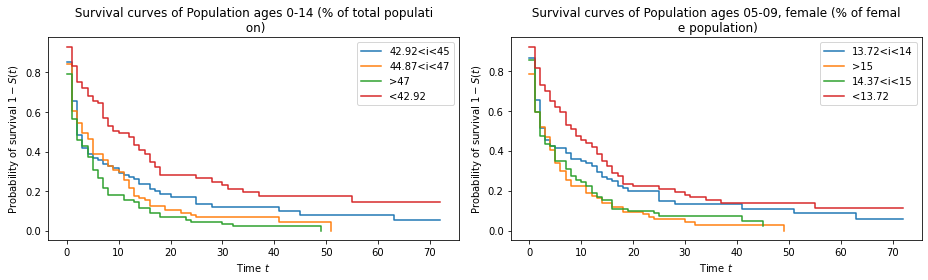

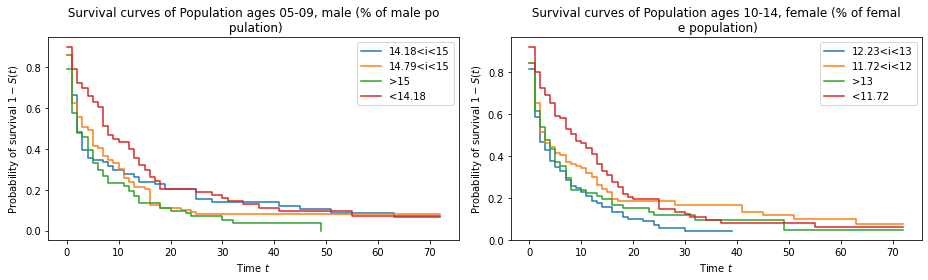

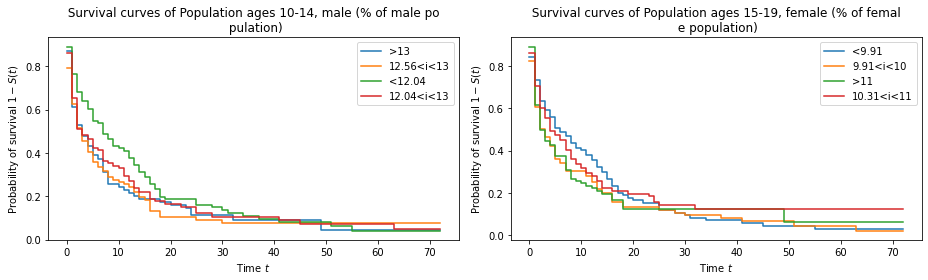

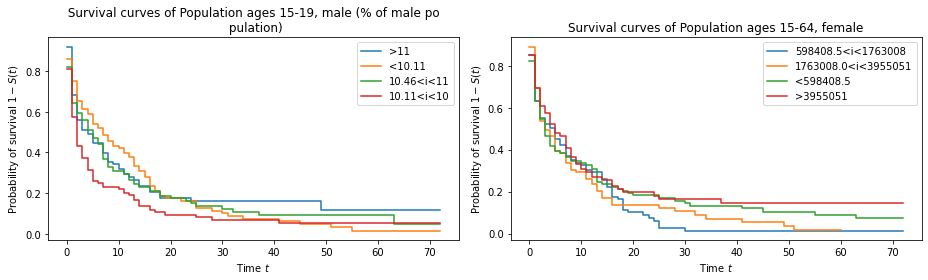

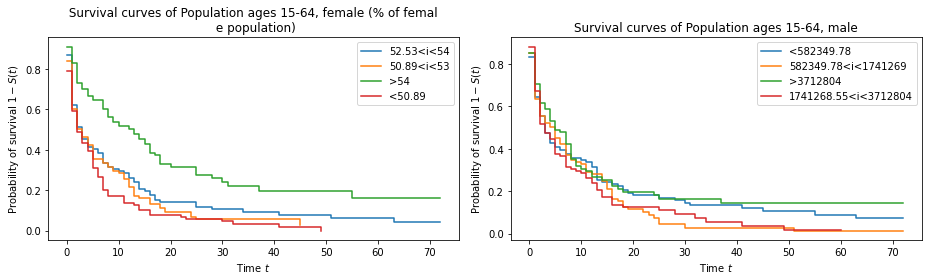

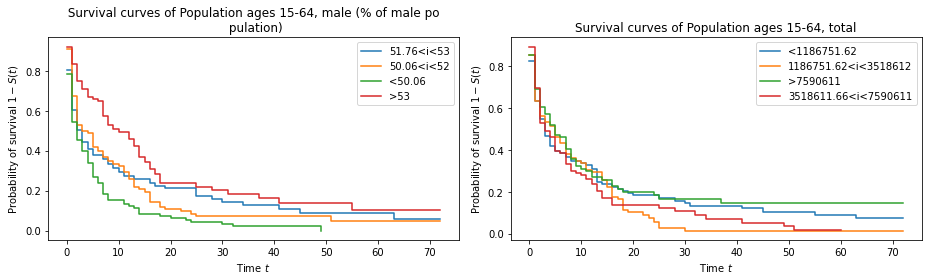

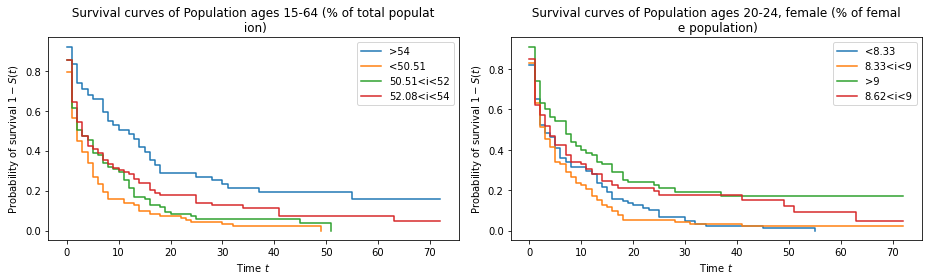

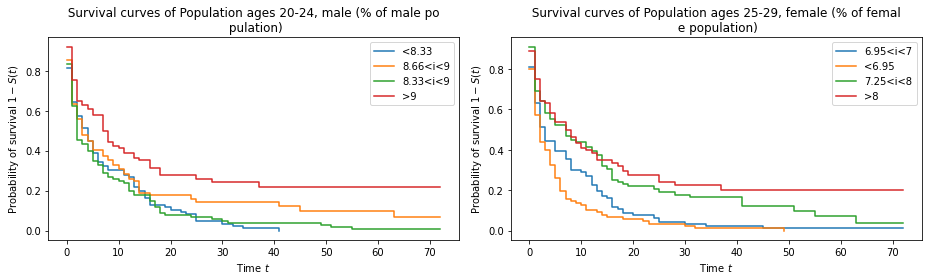

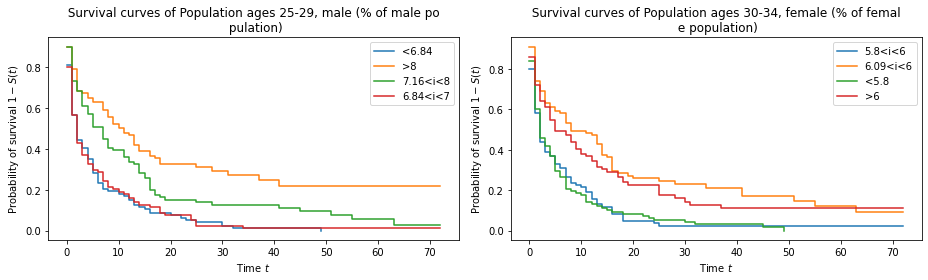

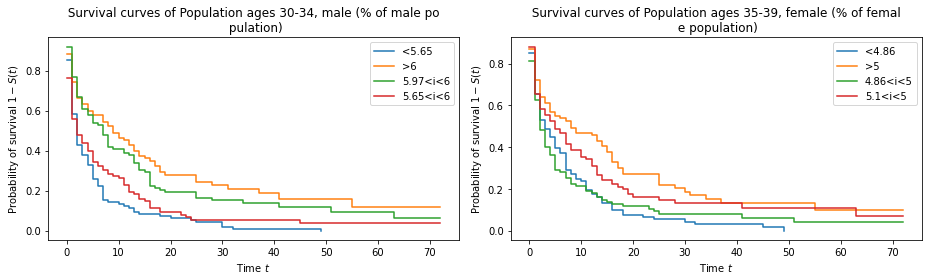

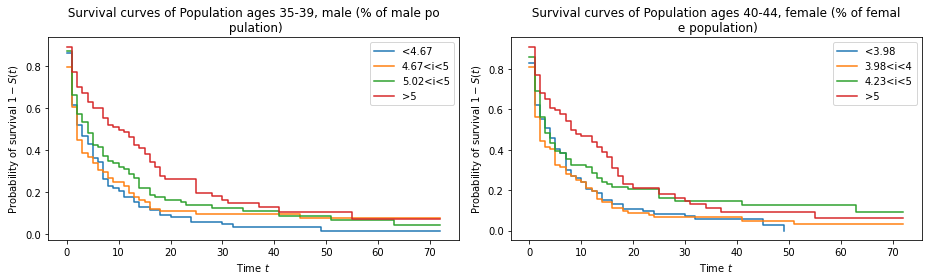

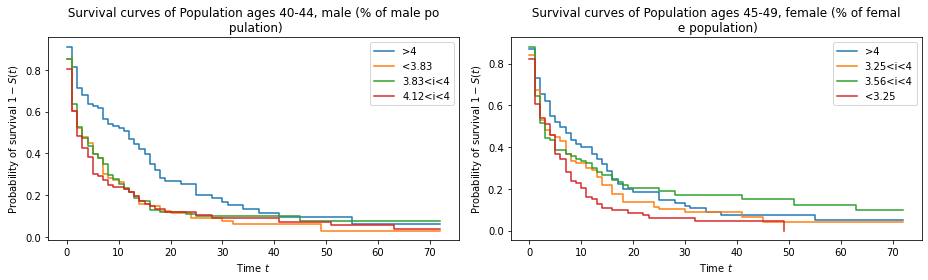

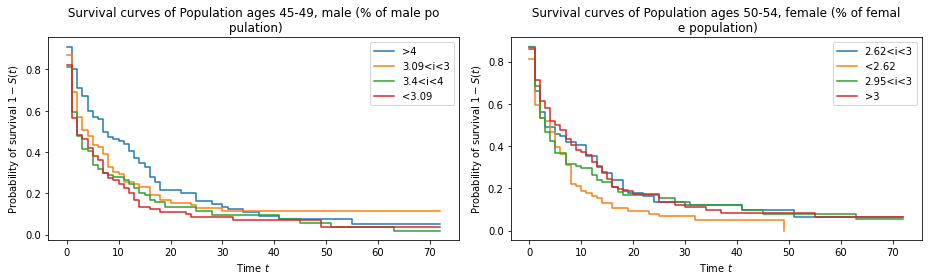

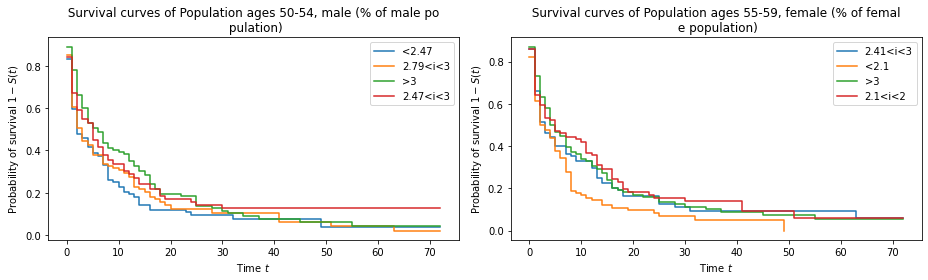

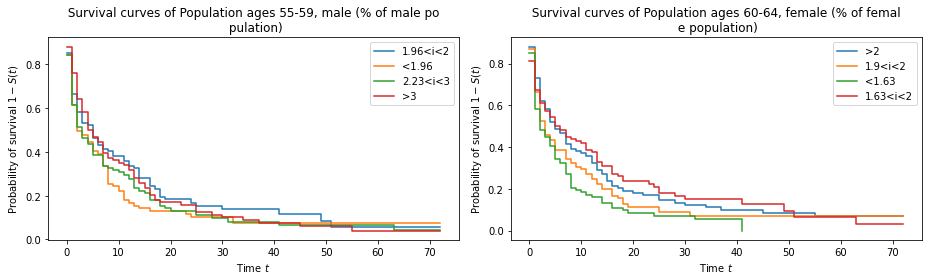

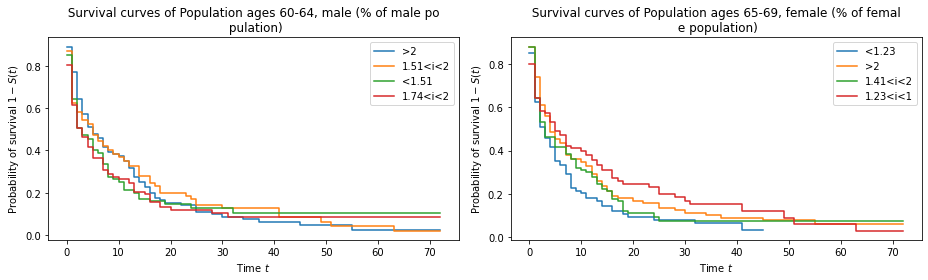

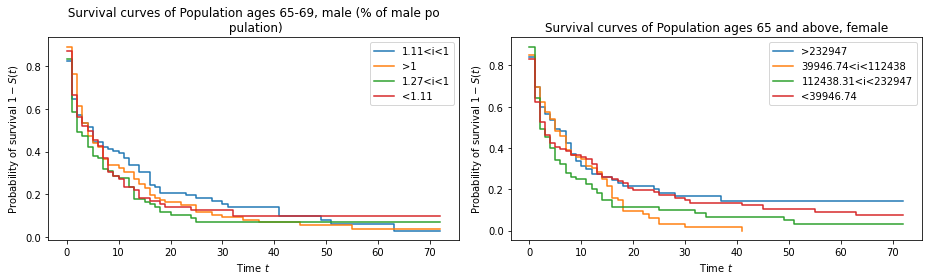

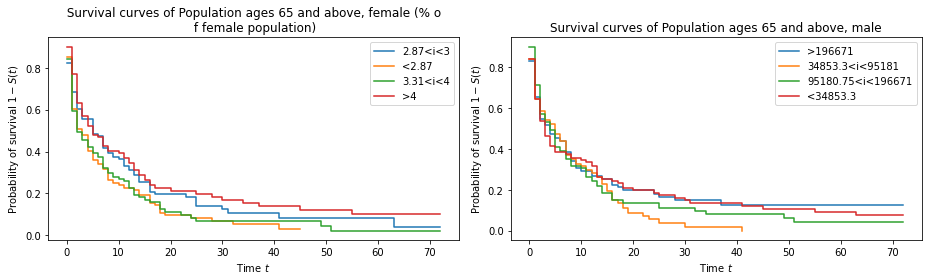

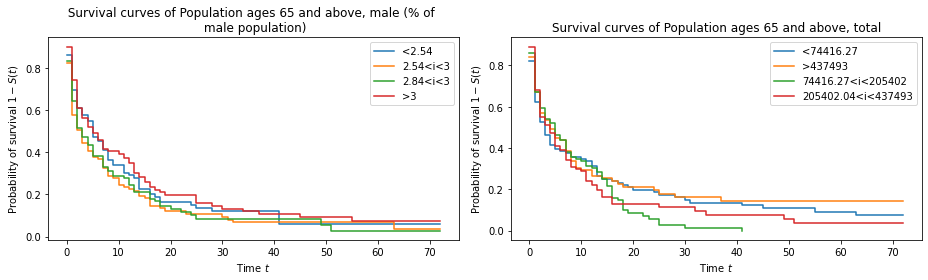

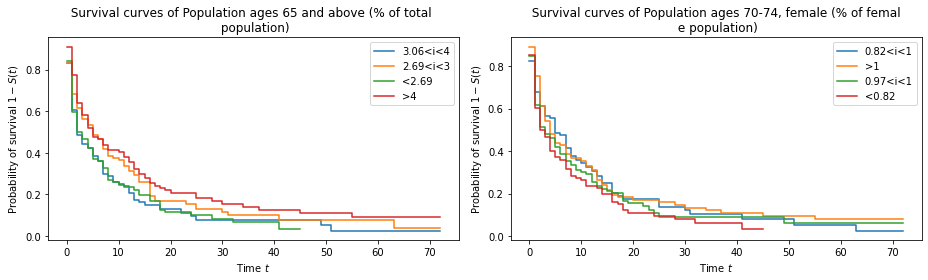

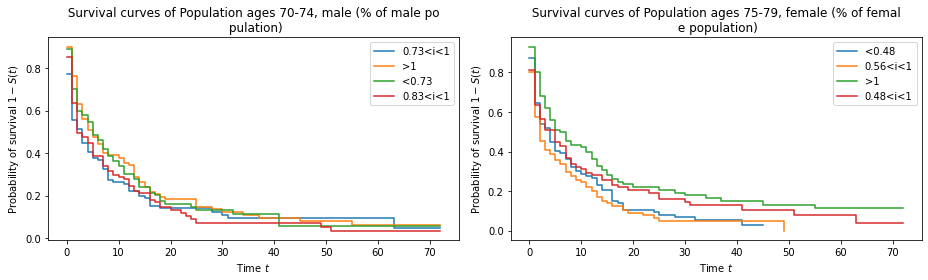

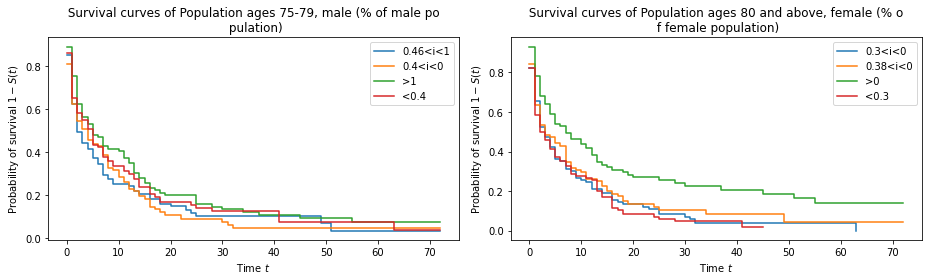

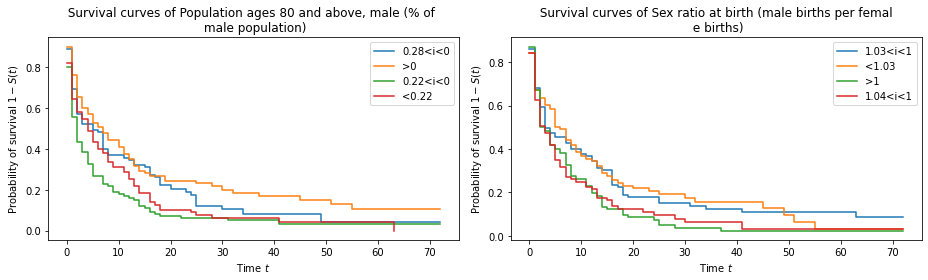

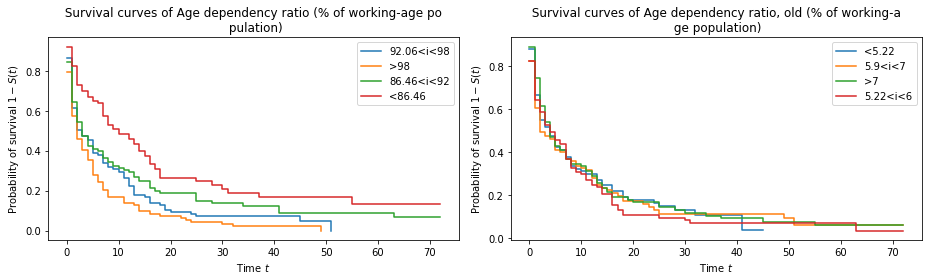

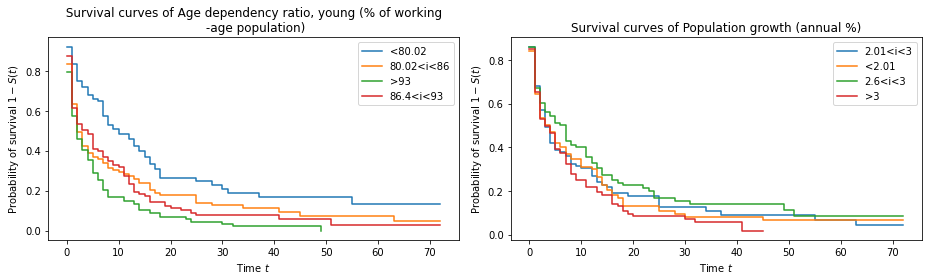

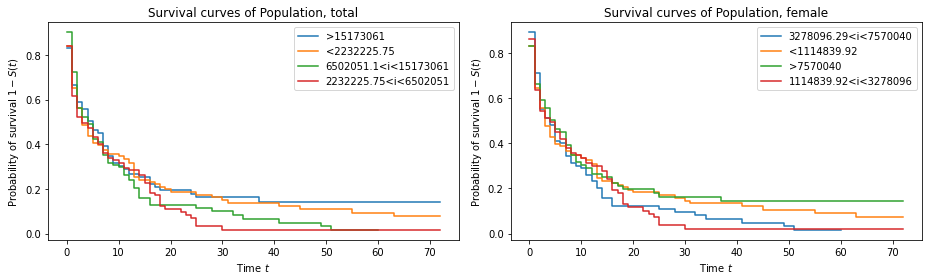

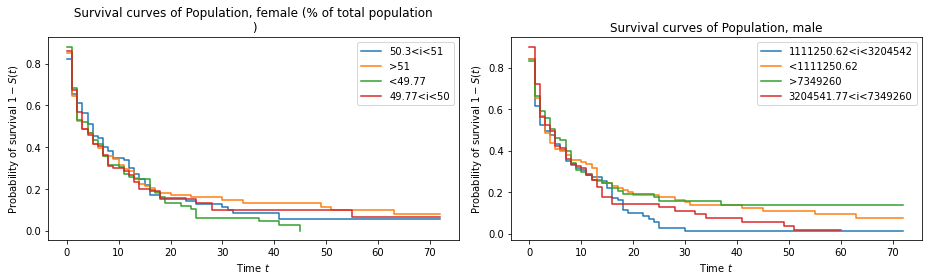

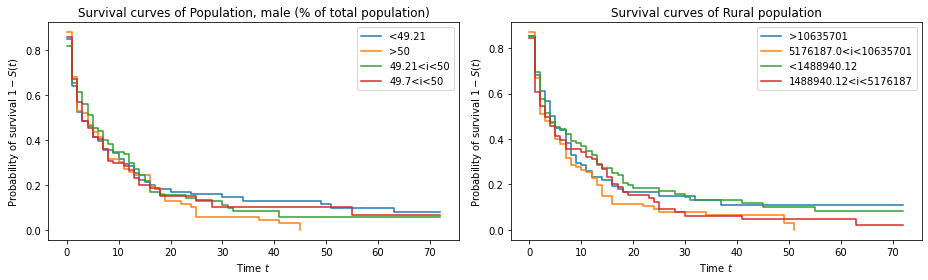

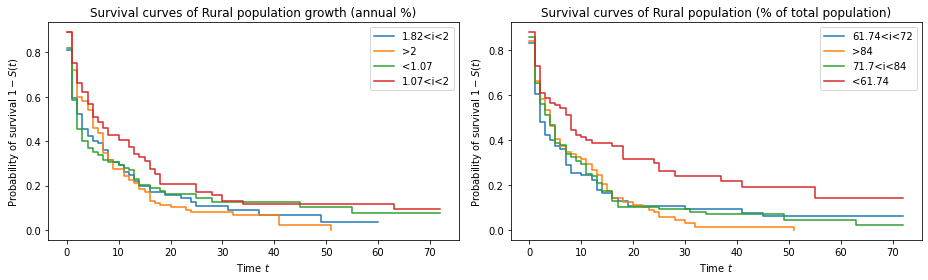

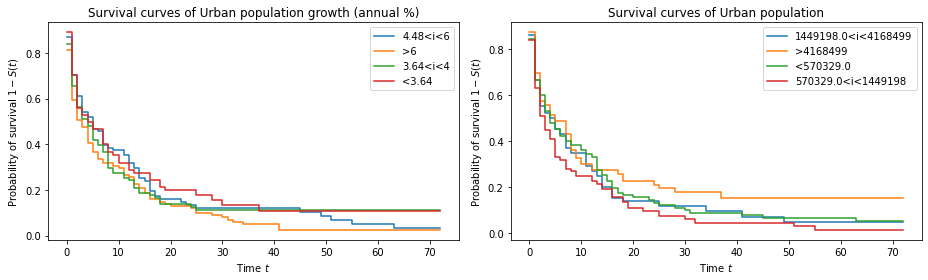

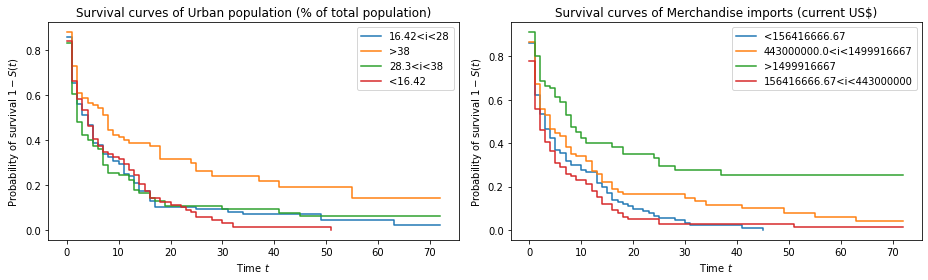

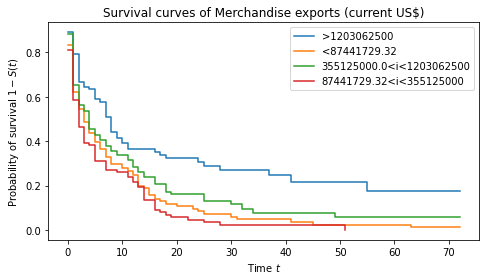

In [22]:
for two_var in sub_list_var :
    plt.figure(figsize=(13, 4))
    if len(two_var) == 2 :
        plt.subplot(1, 2, 1)
        plot_sf_factors(data, two_var[0])
        plt.subplot(1, 2, 2)
        plot_sf_factors(data, two_var[1])
    else :
        plt.subplot(1, 2, 1)
        plot_sf_factors(data, two_var[0])

On these representations, we can see that the variables which have a strong impact on the shape of the survival curves are those linked to :
 - **Birth and death rates**
 - **Exports and imports of goods**
 - **Aids and grants**
 - **Urban or rural population**
 
---

# Get the current situation

## Visualize the last survival curves

In this section, we'll try to visualize survival curves for the most recent country periods by using predictions.

To begin with, we'll divide our data into two dataframes.
- **A train dataframe**: all periods with an end date
- **A test dataframe**: All periods in progress

In [71]:
# We start by dropping the columns that we doesn't need for X data
X = data.drop(columns=["Country", "Start", "End", "Duration", "Status"])

# We scale the data
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = X.columns

# We define y data
y = data[["Status", "Duration"]].to_records(index=False)
X_scaled_new = pd.concat([data[["Country", "End", "Status", "Duration"]].reset_index(), X_scaled], axis=1, ignore_index=False)

# We define train and test dataframes
train = X_scaled_new[X_scaled_new["End"] != 2022]
test = X_scaled_new[X_scaled_new["End"] == 2022]

X_train = train.drop(columns=["Country", "End", "Status", "Duration"])
X_train.index = train["Country"]
X_train = X_train.drop(columns=["index"])
y_train = train[["Status", "Duration"]].to_records(index=False)

X_test = test.drop(columns=["Country", "End", "Status", "Duration"])
X_test.index = test["Country"]
X_test = X_test.drop(columns=["index"])

In [72]:
set_config(display="text")

Now that we have our train and test dataframes, we can apply the <a href="https://en.wikipedia.org/wiki/Proportional_hazards_model">Cox's proportional hazard's model</a> using the `CoxPHSurvivalAnalysis` function.

We've decided to use all the periods available to us for our test dataset, even those we'll want to visualize/predict. As a result, we'll have some overlearning in our results. This doesn't really matter, because what we want is to visualize the most recent prediction curves for each African country.

In [73]:
estimator = CoxPHSurvivalAnalysis(alpha=0.001)
estimator.fit(X_scaled, y)

CoxPHSurvivalAnalysis(alpha=0.001)

We can observe the value of the coefficients for each variable in our dataset. The coefficient corresponds to the <a href = "https://en.wikipedia.org/wiki/Hazard_ratio">log hazard ratio</a>.

In [74]:
for i, j in zip(pd.Series(estimator.coef_, index=X_scaled.columns), X_scaled.columns) :
    print(var_description.loc[j, "description"],":",i)

Agricultural land (sq. km) : -0.4871469413009909
Agricultural land (% of land area) : 0.2352717818414001
Arable land (hectares) : -0.09505977877254665
Arable land (hectares per person) : -0.2412245788206518
Arable land (% of land area) : 0.45564082235587783
Permanent cropland (% of land area) : 0.32688613473175776
Land area (sq. km) : 1.6200960307820143
Surface area (sq. km) : -0.6914156100079708
Grants, excluding technical cooperation (BoP, current US$) : 0.7661491950958104
Technical cooperation grants (BoP, current US$) : 0.1533788457940308
Net bilateral aid flows from DAC donors, Germany (current US$) : 0.32852130746222585
Net bilateral aid flows from DAC donors, Total (current US$) : -0.6320455003462131
Net official development assistance and official aid received (current US$) : 2.2892502723952513
Net official development assistance and official aid received (constant 2020 US$) : 2.2083591905150515
Net official development assistance received (current US$) : -2.679179324007149
Net

Now we can apply predictions to our test set based on our model. We will then plot the predicted curves for each country.

In [75]:
pred_surv = estimator.predict_survival_function(X_test)

In [76]:
dico_country_index = {}
for i, j in zip(X_test.index, range(len(X_test))) :
    dico_country_index[i] = j

In [77]:
def plot_country_sf(country, pred_surv, ret="plot") :
    last_period = data[data["Country"] == country]
    last_period = last_period[last_period["End"]==2022]
    last_period.index=range(len(last_period))
    start_year = last_period["Start"][0]
    period = 2022-start_year
    ps = pred_surv[dico_country_index[country]]
    plt.step(ps.x,ps.y)
    plt.axvline(period, color="red", linestyle="--", label="2022")
    plt.title("Survival function of {}".format(country))
    plt.legend(loc="upper right")
    plt.xlabel("Time since last coup or country creation")
    plt.ylabel("Probability of surviving to a coup")
    plt.ylim(0,1)
    if ret == "time" :
        return period

In [78]:
countries = list(pd.unique(data["Country"]))
sub_list_countries = [countries[i:i+2] for i in range(0, len(countries), 2)]

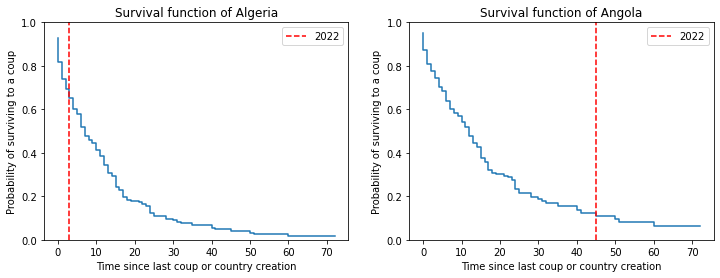

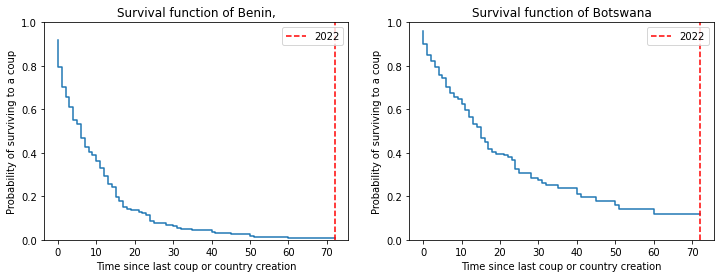

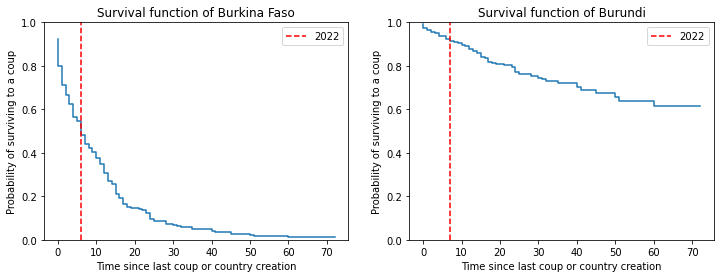

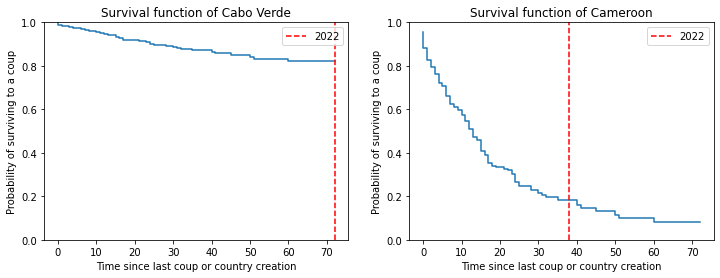

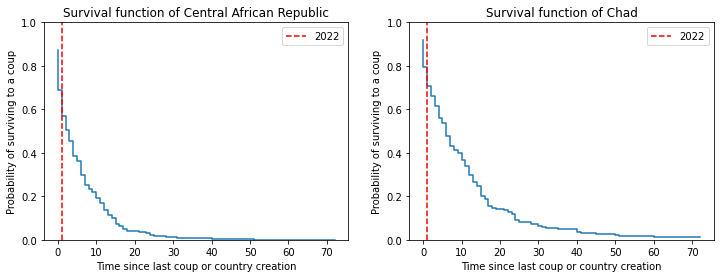

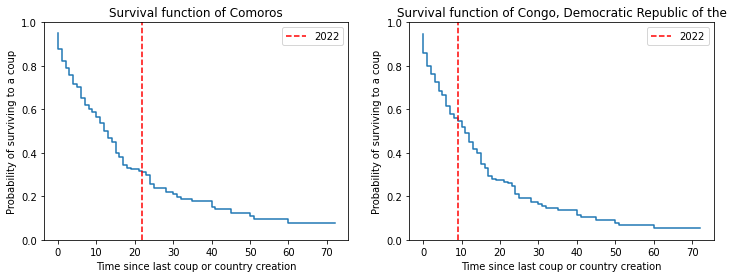

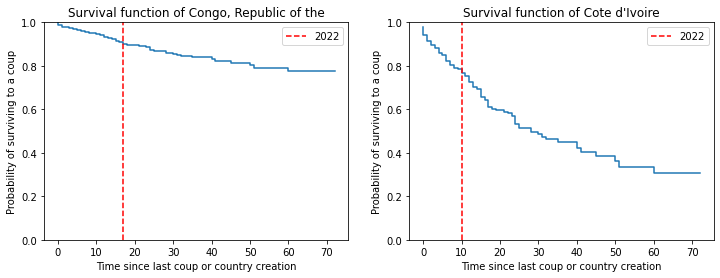

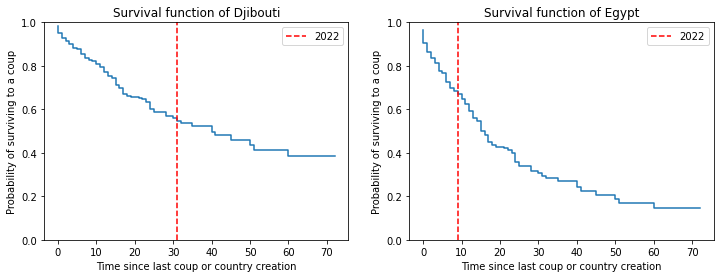

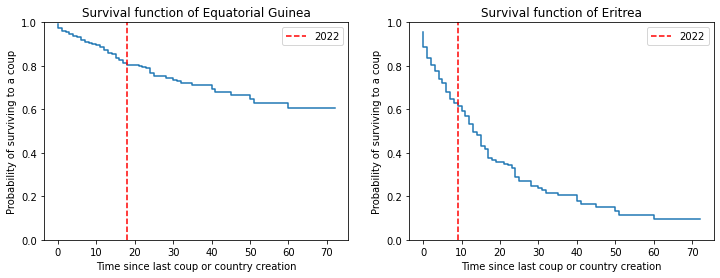

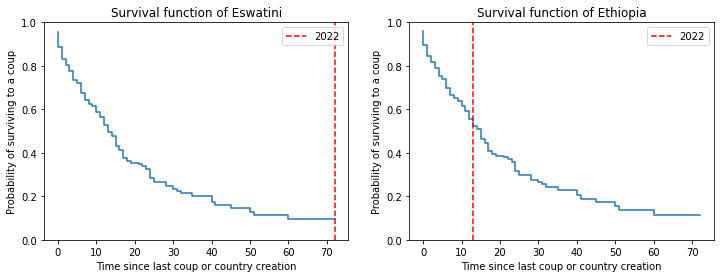

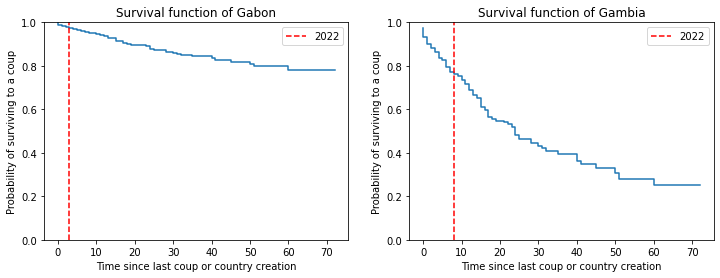

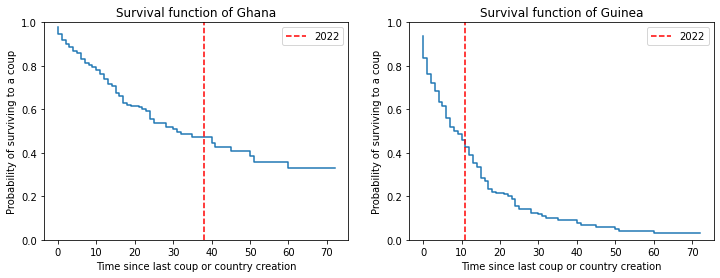

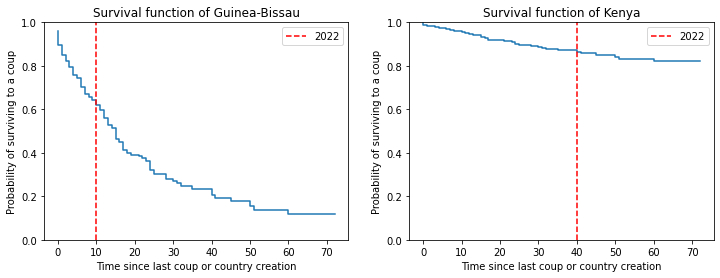

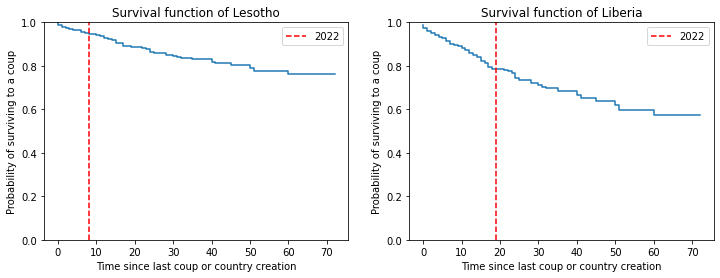

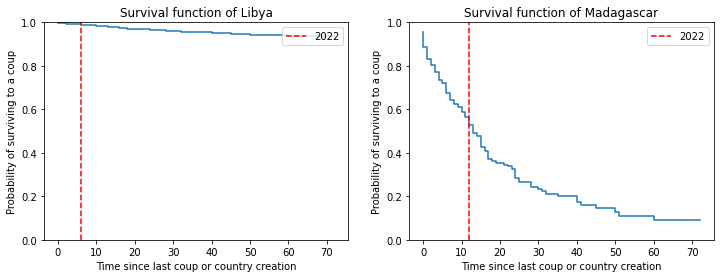

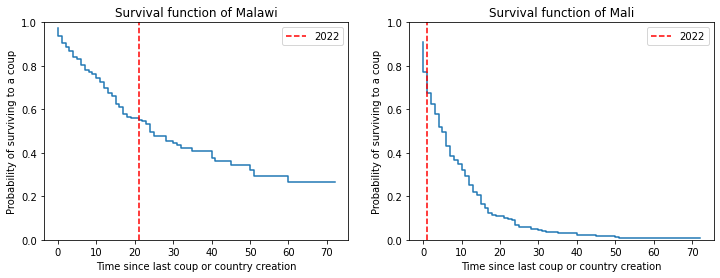

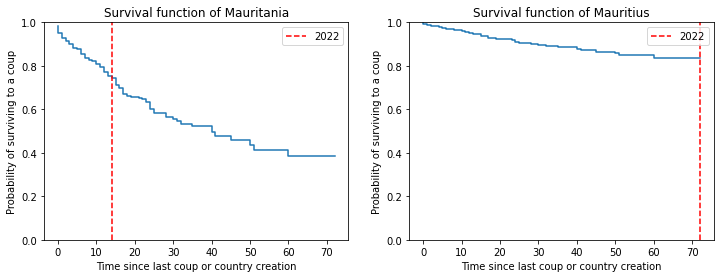

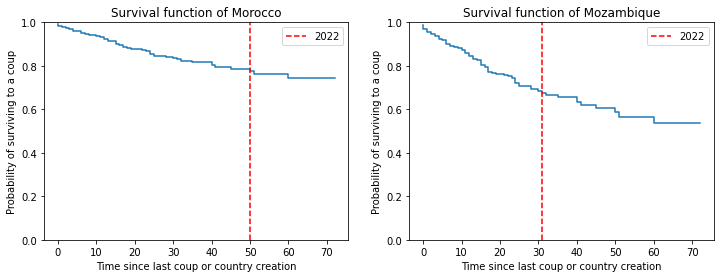

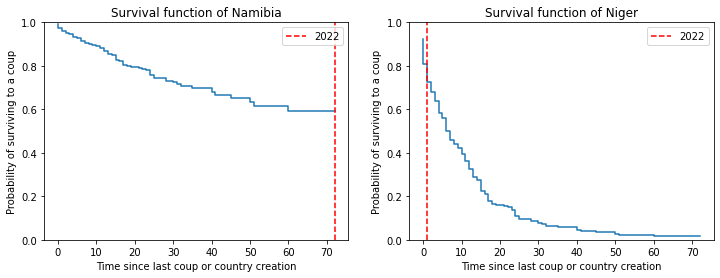

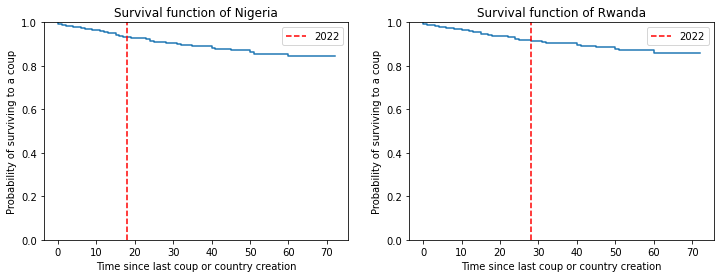

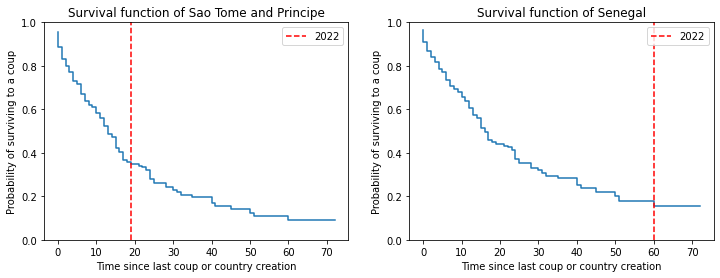

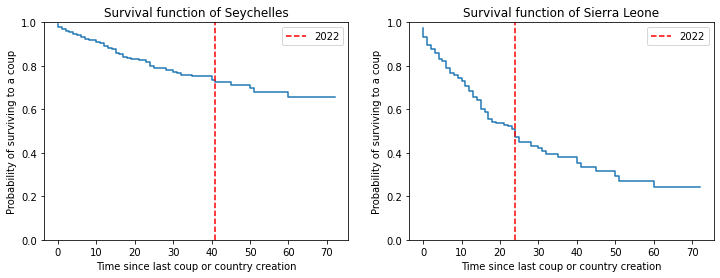

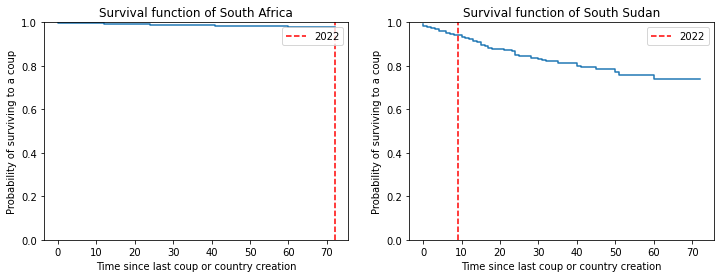

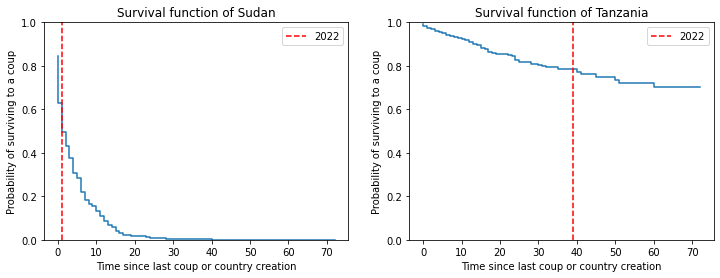

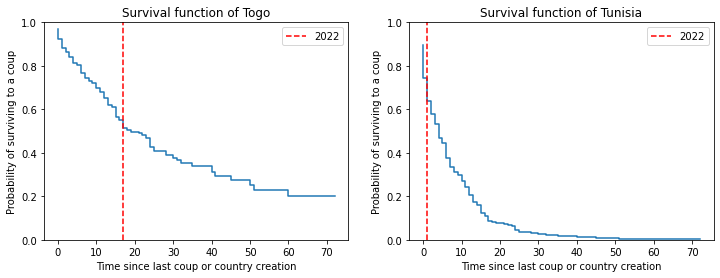

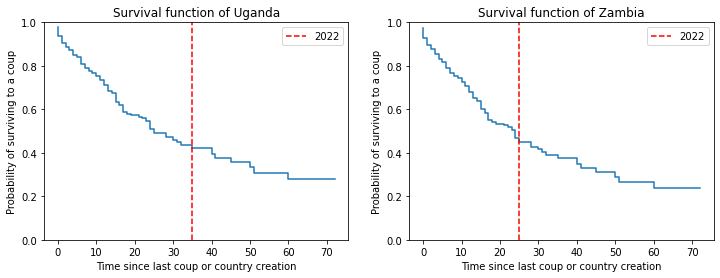

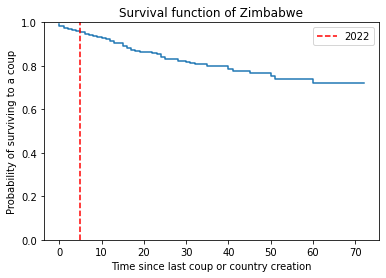

In [79]:
for two_countries in sub_list_countries :
    if len(two_countries) == 2 :
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plot_country_sf(two_countries[0], pred_surv)
        plt.subplot(1, 2, 2)
        plot_country_sf(two_countries[1], pred_surv)
    else :
        plt.figure(figsize=(6, 4))
        plt.subplot(1, 1, 1)
        plot_country_sf(two_countries[0], pred_surv)

On these representations, the survival curves for most countries seem consistent with their geopolitical situations. However, for some countries that have never or not for a long time experienced a coup d'état (e.g. Benin or Botswana), the data may be distorted. This is because we take the averages of each variable over long periods, and values that were low 50 years ago may be higher now, and vice versa.

## Countries at risk

We'll try to create a score that takes into account the probability of surviving a coup and the time elapsed in years since the start of the current period. This score will enable us to see which countries are most at risk of an attempted or actual coup d'état.

The formula of the $\theta_{C}$ score for a country $C$ we'll use is :

$$\theta_{C}(S_{C}(t),t) = \frac{1-S(t)}{t} \times 100$$

Where $t$ represents the time in years since the last coup d'état or the creation of the country, and $S_{C}(t)$ the probability of a coup d'état taking place fo a country $C$.

In [80]:
dico_score = {}

for country in countries :   
    last_period = data[data["Country"] == country]
    last_period = last_period[last_period["End"]==2022]
    last_period.index = range(len(last_period))
    nb_years = 2022-last_period["Start"][0]
    closet_number = min(pred_surv[dico_country_index[country]].x, key=lambda x: abs(x - nb_years))
    dico = {}
    for i, j in zip(pred_surv[dico_country_index[country]].x, pred_surv[dico_country_index[country]].y) :
        dico[i] = j
    dico_score[country] = (dico[closet_number]/nb_years)*100

dico_score_sorted = dict(sorted(dico_score.items(), key=lambda item: item[1], reverse=True))
for nb, (key, val) in zip(range(1,len(dico_score_sorted.keys())+1), dico_score_sorted.items()) :
    print("{}.".format(nb),key,":",round(val,3))

1. Niger : 80.914
2. Chad : 79.695
3. Mali : 77.245
4. Tunisia : 74.268
5. Central African Republic : 68.944
6. Sudan : 63.122
7. Gabon : 32.584
8. Algeria : 23.14
9. Zimbabwe : 19.167
10. Libya : 16.513
11. Burundi : 13.187
12. Lesotho : 11.879
13. South Sudan : 10.469
14. Gambia : 9.668
15. Burkina Faso : 9.086
16. Cote d'Ivoire : 7.837
17. Egypt : 7.582
18. Eritrea : 6.996
19. Guinea-Bissau : 6.43
20. Congo, Democratic Republic of the : 6.211
21. Mauritania : 5.367
22. Congo, Republic of the : 5.348
23. Nigeria : 5.183
24. Madagascar : 4.692
25. Equatorial Guinea : 4.512
26. Ethiopia : 4.29
27. Guinea : 4.158
28. Liberia : 4.145
29. Rwanda : 3.284
30. Togo : 3.232
31. Malawi : 2.665
32. Mozambique : 2.211
33. Kenya : 2.186
34. Sierra Leone : 2.124
35. Tanzania : 2.016
36. Sao Tome and Principe : 1.872
37. Zambia : 1.868
38. Djibouti : 1.8
39. Seychelles : 1.792
40. Morocco : 1.574
41. Comoros : 1.445
42. South Africa : 1.362
43. Uganda : 1.245
44. Ghana : 1.241
45. Mauritius : 1.163

Given the current political situation, this ranking is fairly coherent overall. There are a few inconsistencies, however, such as with Lesotho when we look at <a href="https://www.theglobaleconomy.com/rankings/wb_political_stability/Africa/">ranking of the most political stable countries in Africa</a>.

We can look at which countries have suffered coups or attempted coups in 2022 and 2023 and see where they stand in our ranking:

- 2022 :
    - Burkina Faso : **15**
- 2023 : 
    - Sudan : **6**
    - Niger : **1**
    - Gabon : **7**

These resuts show that World Bank data can give us a fairly good indication of the political situation in African countries. As mentioned above, more detailed data on politics and corruption would enable us to refine this ranking.

---

# Measuring the Performance of Survival Models

We'll now look at a mathematical approach to measuring the performance of our model. To do this, we'll use <a href="https://statisticaloddsandends.wordpress.com/2019/10/26/what-is-harrells-c-index/">Harrell's concordance index</a>. It can be interpreted as follows: If the score has a value of 1, then the model predicts perfectly, if it has a value of 0, then the model's prediction is totally wrong.

In [81]:
prediction = estimator.predict(X_scaled)
result = concordance_index_censored(y["Status"], y["Duration"], prediction)
print("Model's score :",round(result[0], 3))

Model's score : 0.751


This is a pretty good score, even if it's far from perfect. This means once again that our model can be improved by selecting variables or adding new data.

---

# Feature Selection: Which Variable is Most Predictive?

The last thing we're going to do is look at the variables that most influence the prediction of our model.

In [42]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

In [43]:
scores = fit_and_score_features(X_scaled.values, y)

In [86]:
pred_variables = pd.Series(scores, index=X_scaled.columns).sort_values(ascending=False)
for var, val in zip(pred_variables.index, pred_variables) :
    print(var_description.loc[var, "description"],":",round(val, 3))

Population ages 25-29, male (% of male population) : 0.611
Population ages 25-29, female (% of female population) : 0.599
Population ages 30-34, male (% of male population) : 0.599
Population ages 15-64, female (% of female population) : 0.597
Population ages 15-64 (% of total population) : 0.597
Population ages 15-64, male (% of male population) : 0.597
Population ages 0-14 (% of total population) : 0.594
Age dependency ratio, young (% of working-age population) : 0.594
Age dependency ratio (% of working-age population) : 0.594
Population ages 0-14, female (% of female population) : 0.593
Population ages 00-04, male (% of male population) : 0.593
Population ages 30-34, female (% of female population) : 0.592
Fertility rate, total (births per woman) : 0.592
Population ages 00-04, female (% of female population) : 0.592
Population ages 0-14, male (% of male population) : 0.591
Population ages 35-39, male (% of male population) : 0.585
Population ages 05-09, female (% of female populatio

We note that no variable clearly stands out in terms of predictability. Nevertheless, we note that several variables at the top of this ranking relate to the proportion of young people (0-34 years) in the population (`Population ages 25-29, male/female (% of male population)`, `Population ages 0-14 (% of total population): 0.594`, `Age dependency ratio, young (% of working-age population): 0.594`). We can see this through the prism of young people opposing regimes that are often old and/or deeply marked by corruption.

---

# Conclusion

In conclusion, this study has enabled us to familiarize ourselves with survival analysis, and to observe its possible fields of application outside medicine.

It also enabled us to gain a better understanding of the political situation in African countries, and to see which of the factors identified by the World Bank are conducive to coups d'état.